In [1]:
%pip install pyarrow 

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Note: you may need to restart the kernel to use updated packages.


In [2]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from plotnine import *
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

import statsmodels.api as sm

from IPython.display import set_matplotlib_formats, display, clear_output
set_matplotlib_formats('retina')

from itertools import combinations

print('\nok')


ok


In [3]:
raw_df = pd.read_feather('data/analysis_df.feather').set_index('id')
raw_df

,is_retracted,publication_year,cited_by_count,ref_length,journal_id,journal_name,n_authors,abstract_indexed,has_doi,has_pmid,concept0,concept1,disrupt,focal_refs,len_I,len_J,novelty_title,novelty_abstract,n_citing
id,,,,,,,,,,,,,,,,,,,
W1000085140,0,2015,8,21,V17140621,Clinical Biochemistry,8,1,1,1,Medicine,None,0.000000,21.0,4.0,4.0,NaN,NaN,8.0
W1000238170,0,2015,23,34,V2764928002,Redox biology,7,1,1,1,Chemistry,Cell biology,0.629630,34.0,22.0,5.0,1.083342,0.644107,27.0
W1000402150,0,2015,1,1,V2764481192,Procedia. Economics and finance,4,1,1,0,Business,None,1.000000,1.0,1.0,0.0,NaN,NaN,1.0
W10005641,0,2013,40,47,V188605413,Carbon,7,1,1,0,None,Optoelectronics,-0.459459,47.0,10.0,27.0,NaN,NaN,37.0
W1000768039,0,2015,50,32,V127530304,Journal of Materials Processing Technology,5,1,1,0,None,None,0.000000,32.0,25.0,25.0,NaN,NaN,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W99822253,1,2012,4,3,V125754415,Proceedings of the National Academy of Science...,7,0,1,1,Medicine,Immunology,1.000000,3.0,3.0,0.0,NaN,NaN,3.0
W998644059,0,2015,4,47,V186231457,Agroforestry Systems,3,1,1,0,Geography,Socioeconomics,-0.500000,47.0,1.0,3.0,NaN,NaN,4.0
W998753227,0,2015,16,38,V186231457,Agroforestry Systems,3,1,1,0,None,None,-0.333333,38.0,6.0,12.0,NaN,NaN,18.0


In [4]:
X_names = 'is_retracted publication_year cited_by_count ref_length n_authors'.split()
Y_names = 'disrupt novelty_title novelty_abstract'.split()
wanted_columns = Y_names + X_names
# df = df[df.disrupt.notna()]
df = raw_df[wanted_columns].copy()
df

,disrupt,novelty_title,novelty_abstract,is_retracted,publication_year,cited_by_count,ref_length,n_authors
id,,,,,,,,
W1000085140,0.000000,NaN,NaN,0,2015,8,21,8
W1000238170,0.629630,1.083342,0.644107,0,2015,23,34,7
W1000402150,1.000000,NaN,NaN,0,2015,1,1,4
W10005641,-0.459459,NaN,NaN,0,2013,40,47,7
W1000768039,0.000000,NaN,NaN,0,2015,50,32,5
...,...,...,...,...,...,...,...,...
W99822253,1.000000,NaN,NaN,1,2012,4,3,7
W998644059,-0.500000,NaN,NaN,0,2015,4,47,3
W998753227,-0.333333,NaN,NaN,0,2015,16,38,3


In [5]:
df.describe()

,disrupt,novelty_title,novelty_abstract,is_retracted,publication_year,cited_by_count,ref_length,n_authors
count,97338.000000,39019.000000,3.881000e+04,113937.000000,113937.000000,113937.000000,113937.000000,113937.000000
mean,-0.209524,0.937335,5.540195e-01,0.083783,2014.157684,20.989205,31.629725,4.935543
std,0.621898,0.144642,2.301399e-01,0.277064,1.975616,68.317896,31.869641,14.337369
min,-1.000000,0.021752,-4.440892e-16,0.000000,2011.000000,0.000000,0.000000,0.000000
25%,-0.692308,0.865254,3.882134e-01,0.000000,2012.000000,2.000000,12.000000,2.000000
50%,-0.333333,0.968393,5.187643e-01,0.000000,2014.000000,9.000000,27.000000,4.000000
75%,0.142857,1.045788,7.153789e-01,0.000000,2016.000000,23.000000,43.000000,6.000000
max,1.000000,1.244391,1.152073e+00,1.000000,2017.000000,9992.000000,1355.000000,2864.000000


In [6]:
def run_ols(df, y_name, X_names):
    df = df[[y_name] + X_names].copy()
    df = df.dropna()
    y = df[y_name]
    X = df[X_names]
    print(y_name, X_names, len(df))
    ols = sm.OLS(y.values, X.values)
    ols_result = ols.fit(cov_type='HC3')
#     print(ols_result)
#     print(ols_result.tvalues)
    ts = dict(zip(X_names, ols_result.tvalues))
    cis = dict(zip(X_names, ols_result.conf_int()))
    return [ts['is_retracted'], *cis['is_retracted']]

f_refs = [
    '',
    'ref_length>10',
    'ref_length<200',
    '10<ref_length<200',
]
f_cbcs = [
    '',
    'cited_by_count>10',
    'cited_by_count<200',
    '10<cited_by_count<200',
]
f_authors = [
     '',
    'n_authors==1',
    'n_authors>1',
    'n_authors>10',
    'n_authors<50'
]
f_years = [
    '',
    *(f'publication_year=={y}' for y in df.publication_year.unique())
]

df = raw_df.copy()
results = []
for y_name in ['disrupt', 'novelty_title', 'novelty_abstract']:
    for f_year in f_years:
        for f_author in f_authors:
            for f_ref in f_refs:
                for f_cbc in f_cbcs:
                    clear_output(wait=True)
                    filters = (f_year, f_author, f_ref, f_cbc)
                    q = "(" + ") & (".join((f for f in filters if f)) + ")"
                    print(y_name, q)
                    data = df.query(q) if any(filters) else df
                    t, ci_low, ci_high = run_ols(data, y_name, X_names)
                    row  = [y_name, *((f or 'all') for f in filters), q, len(data), t, ci_low, ci_high]
                    results.append(row)
multidf = pd.DataFrame(results)
multidf.columns=['outcome', 'year', 'authors', 'ref_length', 'cited_by_count', 'query', 'n', 't', 'ci_low', 'ci_high']
multidf

novelty_abstract (publication_year==2017) & (n_authors<50) & (10<ref_length<200) & (10<cited_by_count<200)
novelty_abstract ['is_retracted', 'publication_year', 'cited_by_count', 'ref_length', 'n_authors'] 2382


,outcome,year,authors,ref_length,cited_by_count,query,n,t,ci_low,ci_high
0,disrupt,all,all,all,all,(),113937,27.781031,0.209603,0.241423
1,disrupt,all,all,all,cited_by_count>10,(cited_by_count>10),52282,15.267141,0.118444,0.153334
2,disrupt,all,all,all,cited_by_count<200,(cited_by_count<200),112961,26.992831,0.202203,0.233867
3,disrupt,all,all,all,10<cited_by_count<200,(10<cited_by_count<200),51306,15.134891,0.117708,0.152729
4,disrupt,all,all,ref_length>10,all,(ref_length>10),87213,20.708550,0.154617,0.186944
...,...,...,...,...,...,...,...,...,...,...
1915,novelty_abstract,publication_year==2017,n_authors<50,ref_length<200,10<cited_by_count<200,(publication_year==2017) & (n_authors<50) & (r...,6140,-0.805693,-0.047639,0.019882
1916,novelty_abstract,publication_year==2017,n_authors<50,10<ref_length<200,all,(publication_year==2017) & (n_authors<50) & (1...,13127,-0.373292,-0.025095,0.017065
1917,novelty_abstract,publication_year==2017,n_authors<50,10<ref_length<200,cited_by_count>10,(publication_year==2017) & (n_authors<50) & (1...,5913,-0.775786,-0.047601,0.020604
1918,novelty_abstract,publication_year==2017,n_authors<50,10<ref_length<200,cited_by_count<200,(publication_year==2017) & (n_authors<50) & (1...,13086,-0.468572,-0.026108,0.016033


In [7]:
a_result = multidf.loc[0]
a_result

outcome             disrupt
year                    all
authors                 all
ref_length              all
cited_by_count          all
query                    ()
n                    113937
t                 27.781031
ci_low             0.209603
ci_high            0.241423
Name: 0, dtype: object

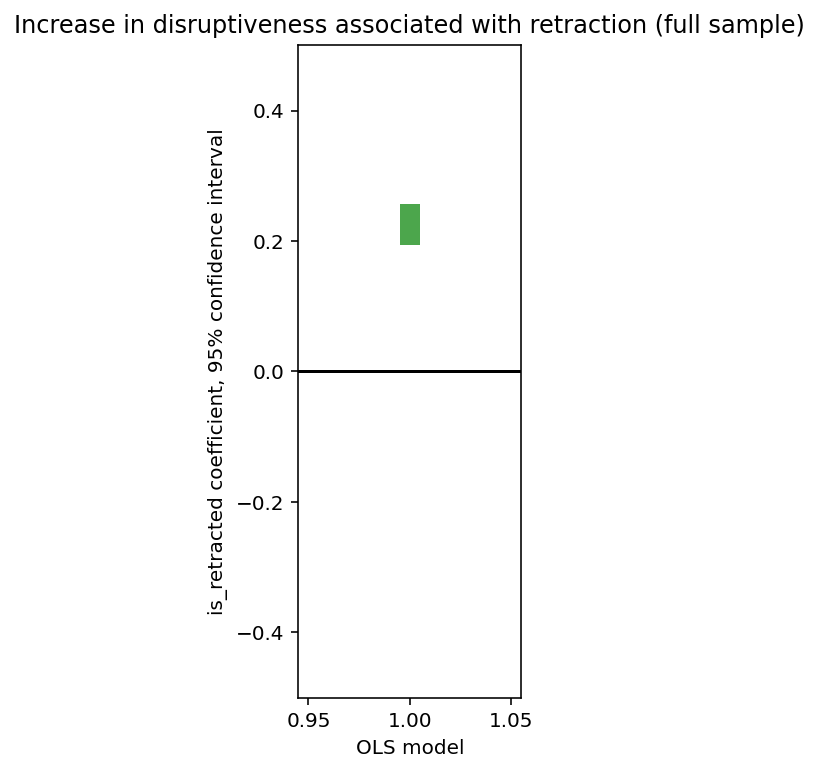

In [8]:
fig, ax = plt.subplots(figsize=(2, 6))
#     plt.axline((row.ci_low, ), (row.ci_high, 1), alpha=0.2)
ax.plot((1, 1), (multidf.loc[0].ci_low, multidf.loc[0].ci_high), alpha=0.7, color='g', lw=10)
ax.set_ylim(-0.5, 0.5)
plt.axhline(0, color='black')
# plt.
plt.ylabel('is_retracted coefficient, 95% confidence interval')
plt.xlabel('OLS model')
_ = plt.title('Increase in disruptiveness associated with retraction (full sample)')

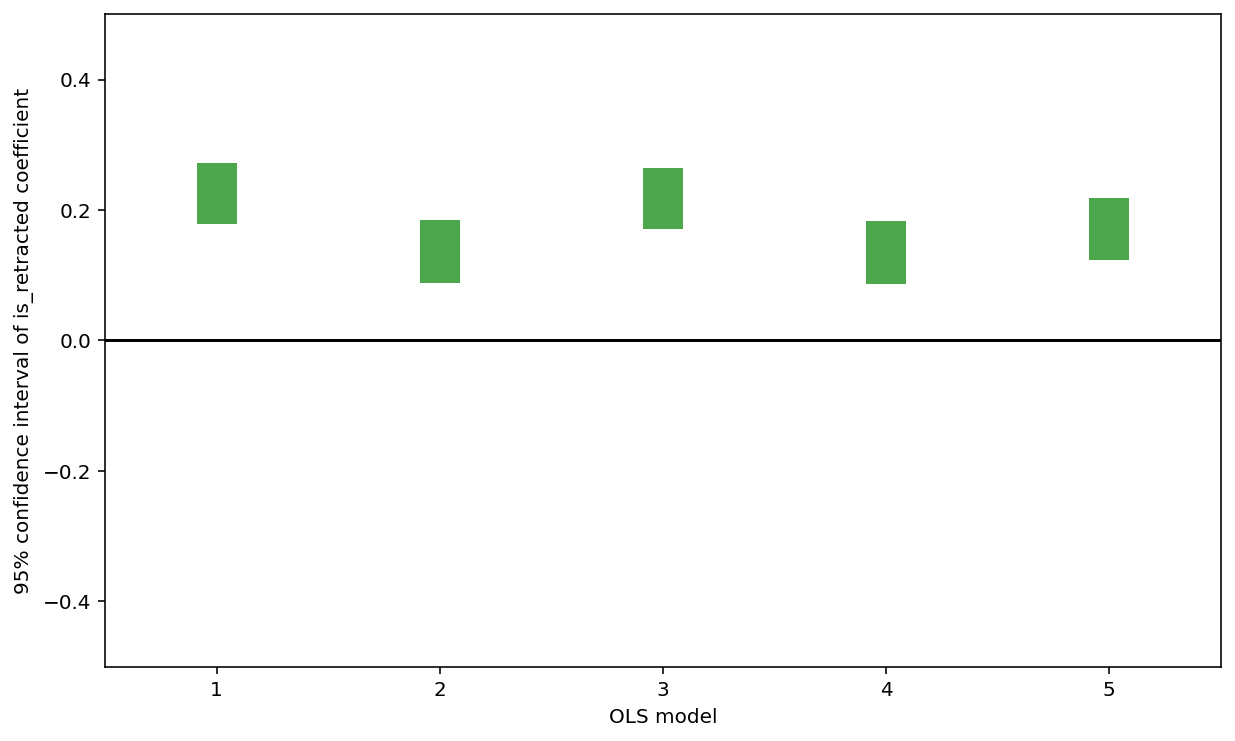

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
#     plt.axline((row.ci_low, ), (row.ci_high, 1), alpha=0.2)
for i in range(5):
    ax.plot((i+1, i+1), (multidf.loc[i].ci_low, multidf.loc[i].ci_high), alpha=0.7, color='g', lw=20)
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(0.5, 5.5)
plt.axhline(0, color='black')
# plt.
plt.ylabel('95% confidence interval of is_retracted coefficient')
_ = plt.xlabel('OLS model')

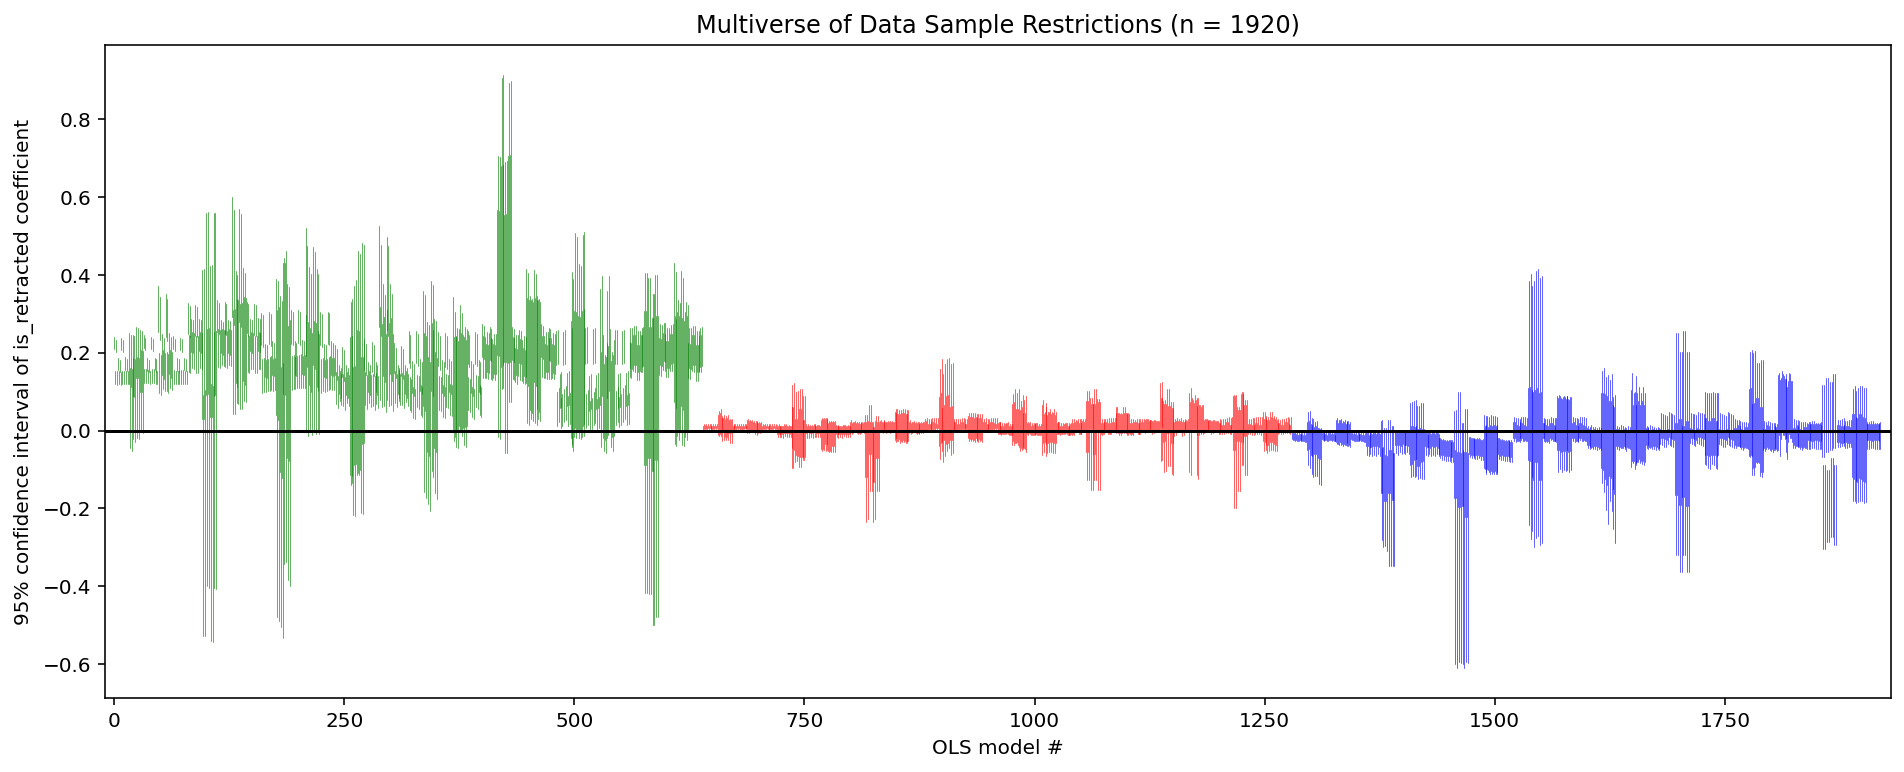

In [11]:
fig, ax = plt.subplots(figsize=(16, 6))
for i, row in enumerate(multidf.itertuples()):
#     plt.axline((row.ci_low, ), (row.ci_high, 1), alpha=0.2)
    hue = {'disrupt': 'g', 'novelty_title': 'r', 'novelty_abstract': 'b'}[row.outcome]
    ax.plot((i, i), (row.ci_low, row.ci_high), alpha=1, color=hue, lw=0.3)
plt.axhline(0, color='black')
plt.ylabel('95% confidence interval of is_retracted coefficient')
ax.set_xlim(-10, len(multidf) + 10)
plt.xlabel('OLS model #')
_ = plt.title(f'Multiverse of Data Sample Restrictions (n = {len(multidf)})')


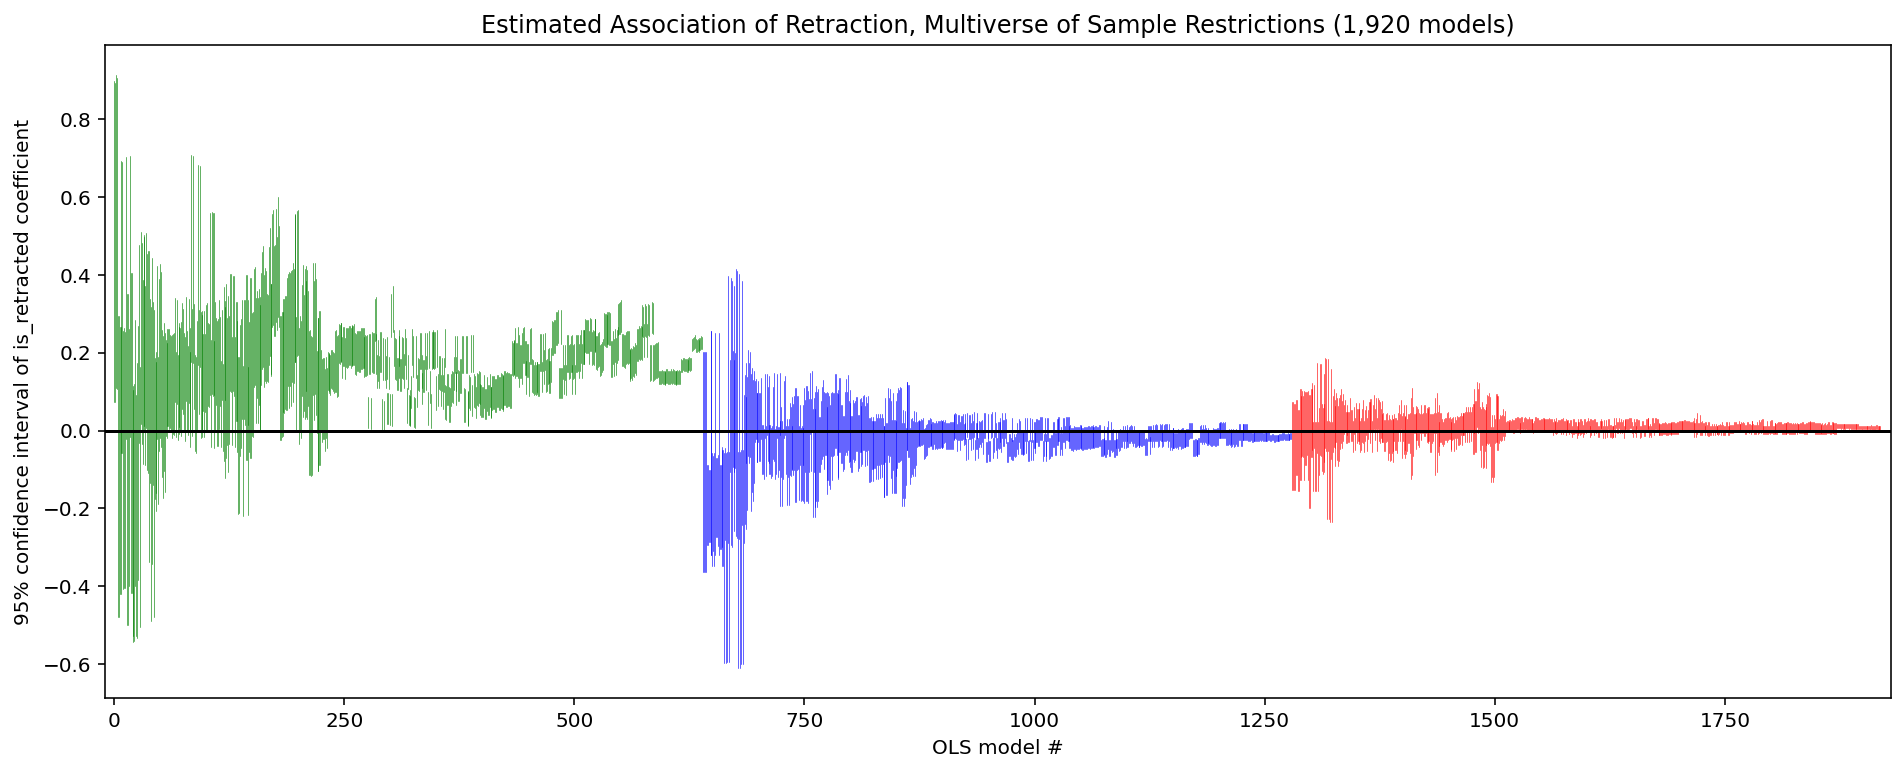

In [12]:
fig, ax = plt.subplots(figsize=(16, 6))
for i, row in enumerate(multidf.sort_values(['outcome', 'n']).itertuples()):
#     plt.axline((row.ci_low, ), (row.ci_high, 1), alpha=0.2)
    hue = {'disrupt': 'g', 'novelty_title': 'r', 'novelty_abstract': 'b'}[row.outcome]
    ax.plot((i, i), (row.ci_low, row.ci_high), alpha=1, color=hue, lw=0.3)
plt.axhline(0, color='black')
plt.ylabel('95% confidence interval of is_retracted coefficient')
ax.set_xlim(-10, len(multidf) + 10)
plt.xlabel('OLS model #')
_ = plt.title(f'Estimated Association of Retraction, Multiverse of Sample Restrictions ({len(multidf):,} models)')


Text(0.5, 1.0, 'T-Value Multiverse of Data Sample Restrictions (1,920 models)')

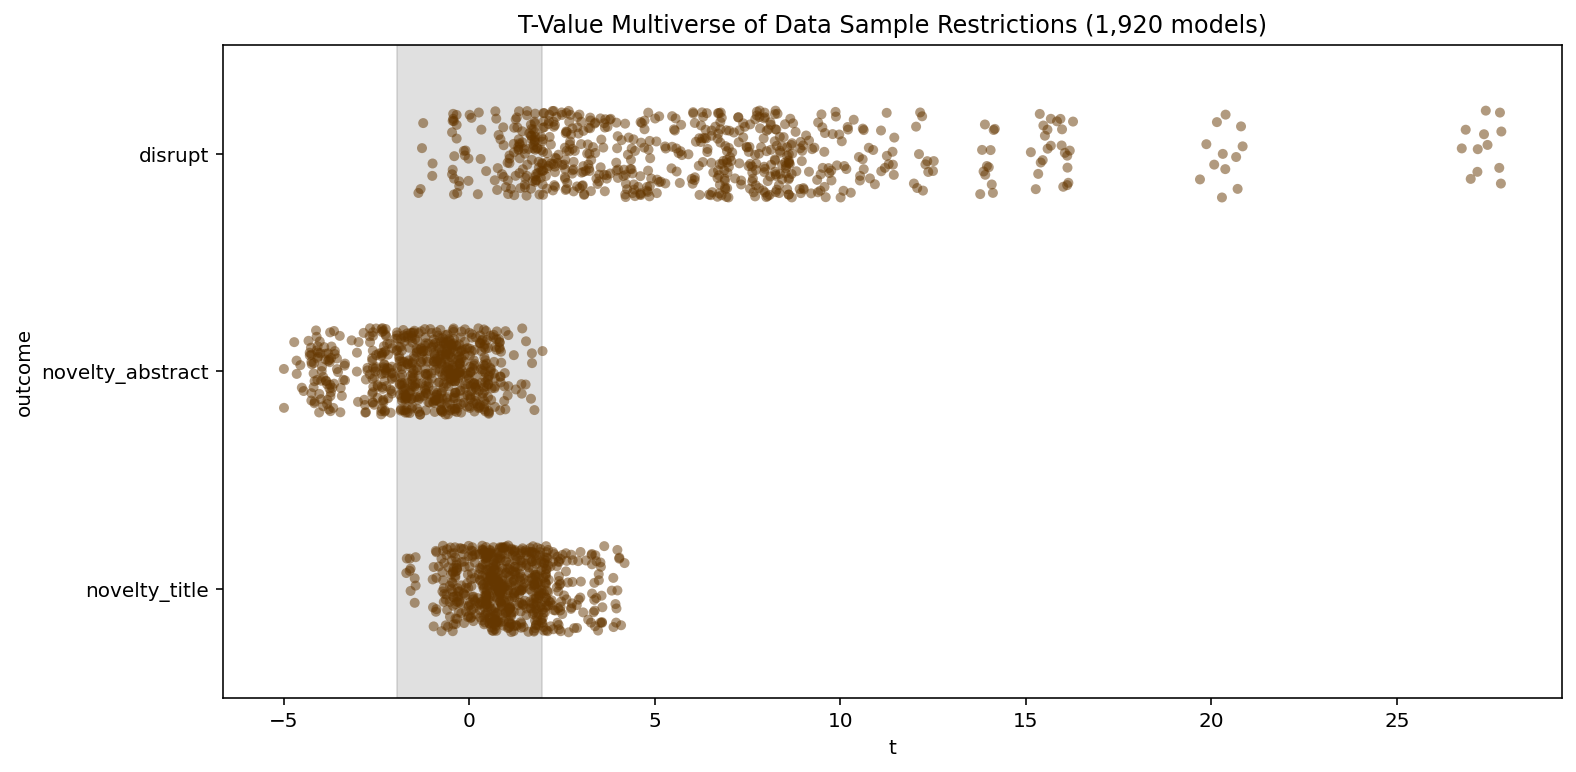

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(data=multidf.sort_values('year'), x='t', y='outcome', size=5, jitter=0.2, alpha=0.5, color='#653700')
ax.axvspan(-1.96, 1.96, alpha=0.3, color='#999')
plt.title(f'T-Value Multiverse of Data Sample Restrictions ({len(multidf):,} models)')


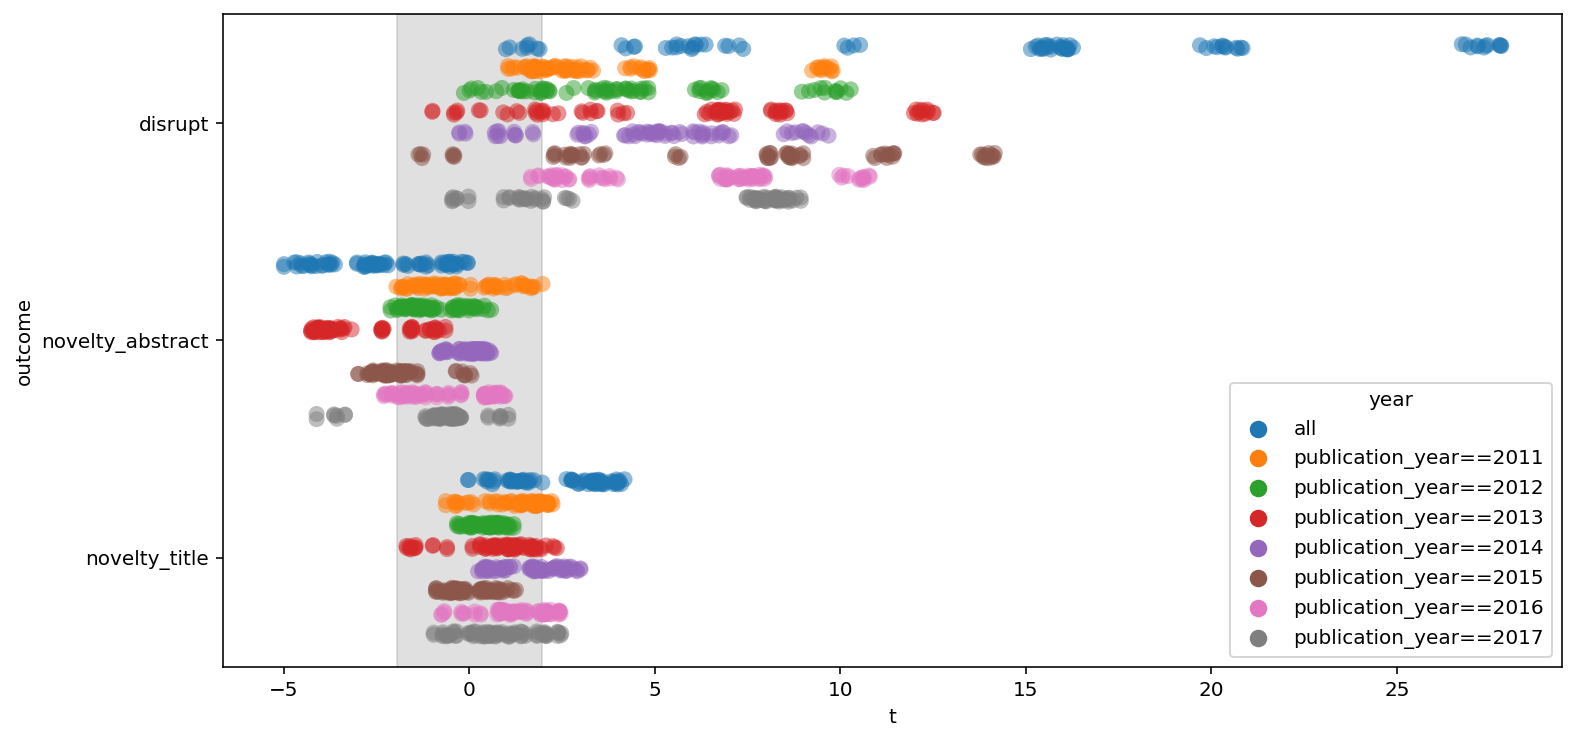

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(data=multidf.sort_values(['year', 'outcome']), x='t', y='outcome', hue='year', size=8, alpha=0.5, dodge=True)
ax.axvspan(-1.96, 1.96, alpha=0.3, color='#999')


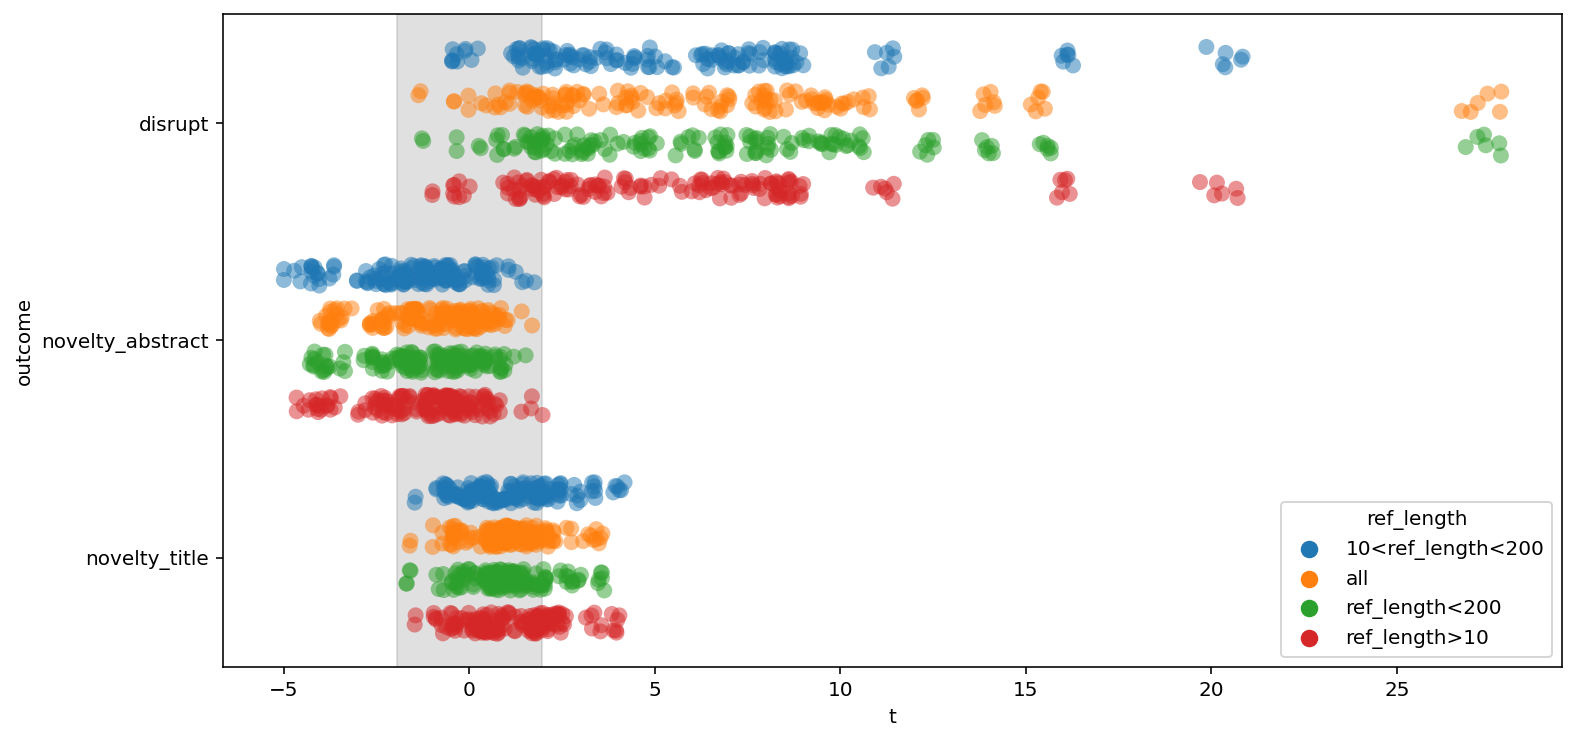

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(data=multidf.sort_values(['ref_length', 'outcome']), x='t', y='outcome', hue='ref_length', size=8, jitter=0.2, alpha=0.5, dodge=True)
ax.axvspan(-1.96, 1.96, alpha=0.3, color='#999')


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.stripplot(data=multidf.sort_values(['authors', 'outcome']), x='t', y='outcome', hue='authors', size=8, jitter=0.2, alpha=0.5, dodge=True)
ax.axvspan(-1.96, 1.96, alpha=0.3, color='#999')
